In [111]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import re
import pickle
from sklearn.preprocessing import StandardScaler,FunctionTransformer,PowerTransformer,OrdinalEncoder,LabelEncoder,OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.model_selection import train_test_split

### 1.Problem Statement : Create a model to predict the drugs based on age, sex, BP, Cholestrol, Na_to_k value.

### 2.Data Collection : Collected the dataset from Kaggle website

In [2]:
data=pd.read_csv(r"C:\Users\yuges\Downloads\drug200.csv")

In [3]:
datac=data.copy()

In [4]:
datac

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY
...,...,...,...,...,...,...
195,56,F,LOW,HIGH,11.567,drugC
196,16,M,LOW,HIGH,12.006,drugC
197,52,M,NORMAL,HIGH,9.894,drugX
198,23,M,NORMAL,NORMAL,14.020,drugX


### 3.EDA

In [5]:
datac.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          200 non-null    int64  
 1   Sex          200 non-null    object 
 2   BP           200 non-null    object 
 3   Cholesterol  200 non-null    object 
 4   Na_to_K      200 non-null    float64
 5   Drug         200 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 9.5+ KB


In [6]:
datac.shape # No missing values

(200, 6)

In [7]:
datac[datac.duplicated()] # No duplicates

,Age,Sex,BP,Cholesterol,Na_to_K,Drug


In [8]:
# Outliers

In [9]:
datac["Drug"].value_counts() # Slightly Imabalanced data

DrugY    91
drugX    54
drugA    23
drugC    16
drugB    16
Name: Drug, dtype: int64

In [10]:
datac.describe()

,Age,Na_to_K
count,200.000000,200.000000
mean,44.315000,16.084485
std,16.544315,7.223956
min,15.000000,6.269000
25%,31.000000,10.445500
50%,45.000000,13.936500
75%,58.000000,19.380000
max,74.000000,38.247000


In [11]:
fv=datac.iloc[:,0:5]
cl=datac.iloc[:,5]

### 4.Data Preprocessing

In [12]:
"".join(fv["Sex"]).isupper() # All are in upper case

True

In [13]:
"".join(fv["BP"]).isupper() # All characters in BP column are in upper case

True

In [14]:
"".join(fv["Cholesterol"]).isupper() # All characters in cholesterol column are in upper case

True

### 5.EDA

In [15]:
datac.columns

Index(['Age', 'Sex', 'BP', 'Cholesterol', 'Na_to_K', 'Drug'], dtype='object')

In [16]:
datac.dtypes

Age              int64
Sex             object
BP              object
Cholesterol     object
Na_to_K        float64
Drug            object
dtype: object

In [17]:
# As Na_to_K is a continuous data i can apply histogram for visualization

<Axes: ylabel='Frequency'>

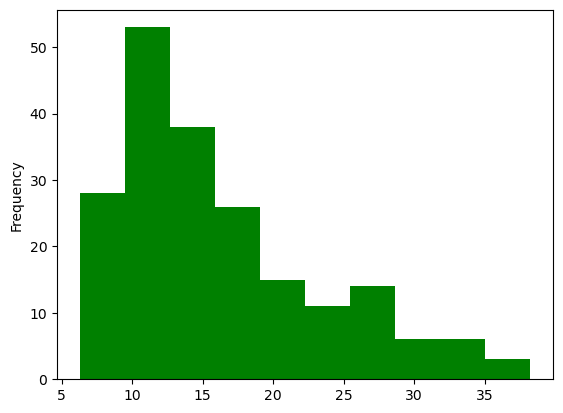

In [18]:
# Checks whether the Na_to_K column is normally distributed or not
# Na_to_K column is not normally distributed
datac["Na_to_K"].plot.hist(color="green")

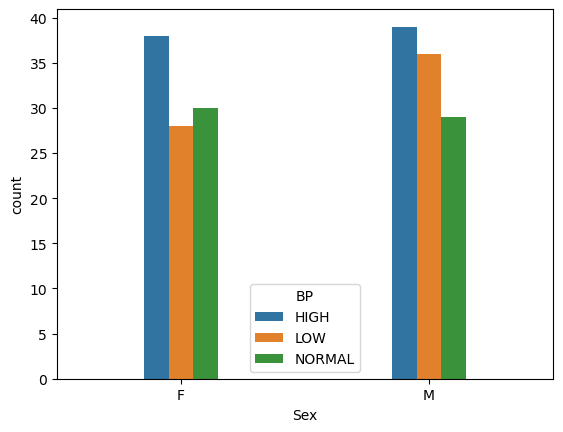

In [19]:
# Gives the count of males and females who are having low, high and normal BP
sns.countplot(x="Sex",data=datac,width=0.3,hue="BP")
plt.show()

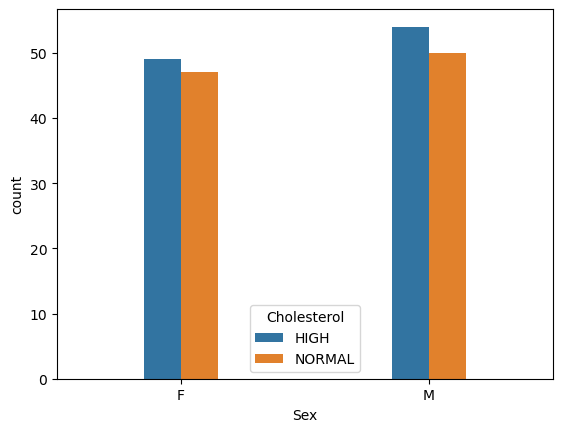

In [20]:
# Gives the count of males and females who are having high and normal cholesterol
sns.countplot(x="Sex",data=datac,width=0.3,hue="Cholesterol")
plt.show()

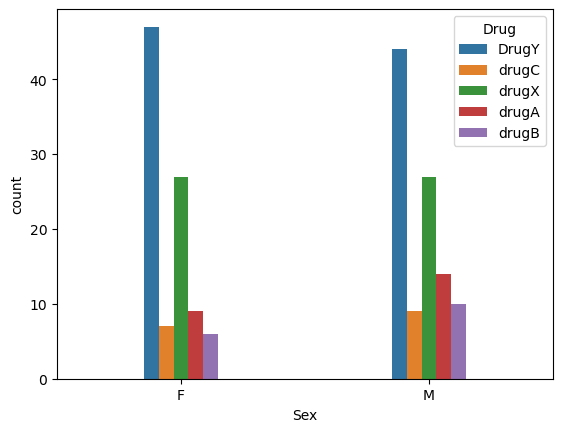

In [21]:
# To see the no. of males and females who are using drugA, drugB, drugC, drugX, drugY
sns.countplot(x="Sex",data=datac,width=0.3,hue="Drug")
plt.show()

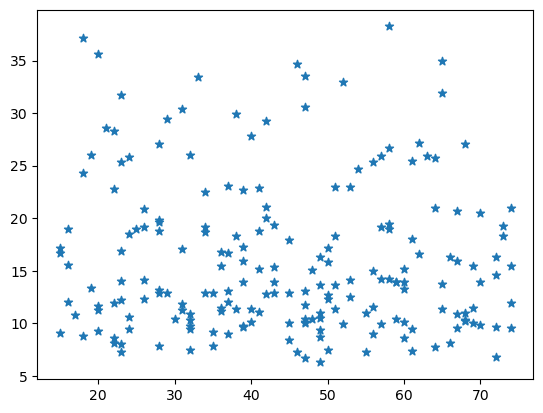

In [22]:
plt.scatter(datac["Age"],datac["Na_to_K"],marker="*")
plt.show()

In [23]:
datac.corr() # Gives the correlation between the numerical columns in datac
# If Age increases by 1 unit, Na_to_K decreases by 63%
# If Na_to_K increases by 1 unit, Age decreases by 63%

C:\Users\yuges\AppData\Local\Temp\ipykernel_1724\2100453418.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  datac.corr() # Gives the correlation between the numerical columns in datac


,Age,Na_to_K
Age,1.000000,-0.063119
Na_to_K,-0.063119,1.000000


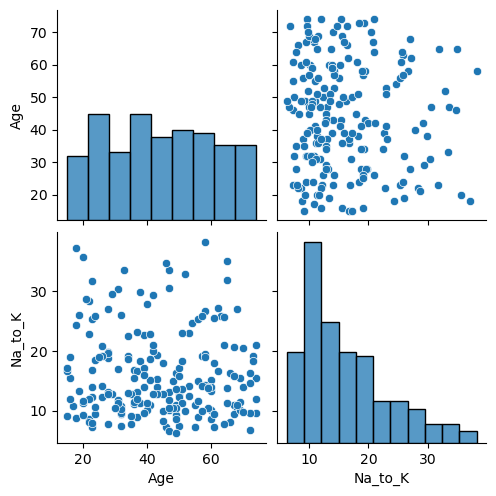

In [24]:
sns.pairplot(datac) # Scatter plot for multiple variables

In [25]:
# To see the number of males and females who have high, normal and low BP 
pd.crosstab(index=datac["Sex"],columns=datac["BP"])

BP,HIGH,LOW,NORMAL
Sex,,,
F,38,28,30
M,39,36,29


In [26]:
# To see the number of males and females who have high,normal cholesterol
pd.crosstab(index=datac["Sex"],columns=datac["Cholesterol"])

Cholesterol,HIGH,NORMAL
Sex,,
F,49,47
M,54,50


In [27]:
# To see the number of males and females who have high BP,Normal Cholesterol and so on
datac.pivot_table(index=["Sex","BP"],columns=["Cholesterol"],aggfunc="count")["Age"]

Cholesterol  HIGH  NORMAL
Sex BP                   
F   HIGH       17      21
    LOW        14      14
    NORMAL     18      12
M   HIGH       18      21
    LOW        17      19
    NORMAL     19      10

### 6.Feature Engineering/Feature Extraction

In [28]:
fv

,Age,Sex,BP,Cholesterol,Na_to_K
0,23,F,HIGH,HIGH,25.355
1,47,M,LOW,HIGH,13.093
2,47,M,LOW,HIGH,10.114
3,28,F,NORMAL,HIGH,7.798
4,61,F,LOW,HIGH,18.043
...,...,...,...,...,...
195,56,F,LOW,HIGH,11.567
196,16,M,LOW,HIGH,12.006
197,52,M,NORMAL,HIGH,9.894
198,23,M,NORMAL,NORMAL,14.020


In [29]:
cl=cl.map({"drugA":0,"drugB":1,"drugC":2,"drugX":3,"DrugY":4})

In [30]:
cle=pd.concat([fv,cl],axis=1)

In [285]:
cle.to_csv("Drugs Clean.csv",index=None) # Using this cleaned data i can deploy the model

In [31]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(fv,cl,test_size=0.2,random_state=1,stratify=cl)
x_train,x_cv,y_train,y_cv=train_test_split(x_train,y_train,test_size=0.2,random_state=1,stratify=y_train)

In [32]:
# You need to convert your data from categorical to numerical.
# As Sex, BP, Cholesterol are categorical i need to convert them into numerical
# To convert them into numerical i can use label encoding as i am using naive bayes algorithm not knn algorithm
from sklearn.preprocessing import LabelEncoder,OneHotEncoder,OrdinalEncoder

In [33]:
lb=LabelEncoder()
ohe=OneHotEncoder(sparse_output=False,drop="first")
oe=OrdinalEncoder()

In [34]:
x_train["Sex"]=ohe.fit_transform(x_train[["Sex"]])

In [35]:
x_cv["Sex"]=ohe.transform(x_cv[["Sex"]])
x_test["Sex"]=ohe.transform(x_test[["Sex"]])

In [36]:
x_train["BP"]=oe.fit_transform(x_train[["BP"]])
x_cv["BP"]=oe.transform(x_cv[["BP"]])
x_test["BP"]=oe.transform(x_test[["BP"]])

In [37]:
x_train["Cholesterol"]=oe.fit_transform(x_train[["Cholesterol"]])
x_cv["Cholesterol"]=oe.transform(x_cv[["Cholesterol"]])
x_test["Cholesterol"]=oe.transform(x_test[["Cholesterol"]])

In [38]:
# Now i'm converted all my features and classes into numerical

In [39]:
# Now i want to check whether my Age and Na_to_K columns are following normal distribution or not as they are numercial

In [40]:
import scipy.stats as ss

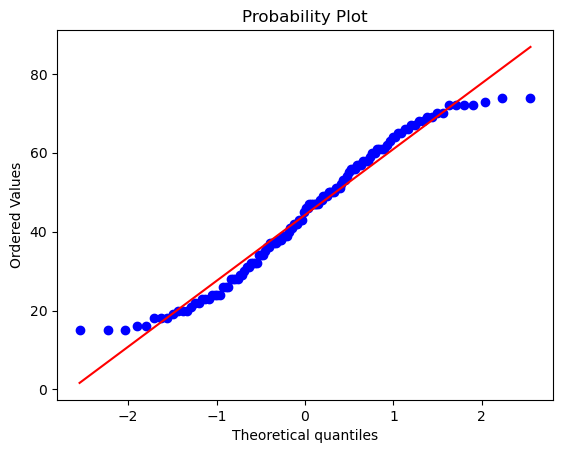

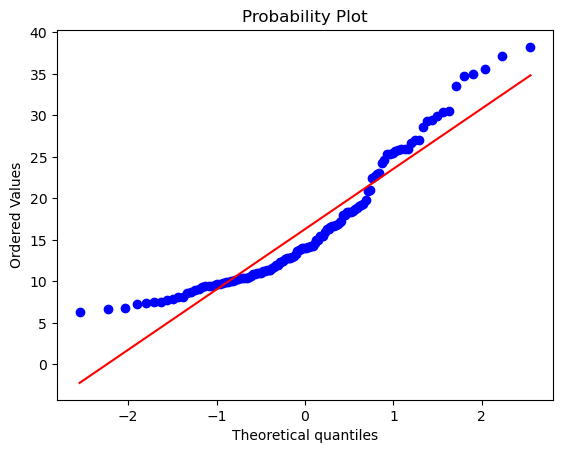

In [41]:
l=["Age","Na_to_K"]
for i in l:
    plt.subplot(111)
    ss.probplot(x_train[i],dist="norm",fit=True,plot=plt)
    plt.show()

In [42]:
# Box-Cox cannot be applied on negative and zeros
# Ye-Johnson can be applied on negative,positive and zeros

In [43]:
from sklearn.preprocessing import FunctionTransformer,PowerTransformer

In [44]:
pt2=PowerTransformer(method="box-cox")

In [45]:
x_train["Age"]=pt2.fit_transform(x_train[["Age"]])

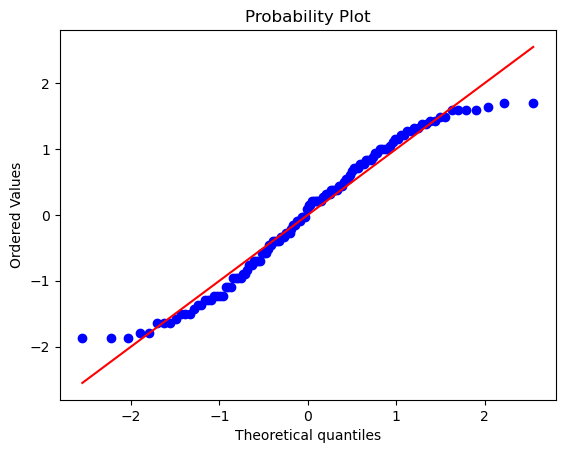

In [46]:
ss.probplot(x_train["Age"],dist="norm",fit=True,plot=plt)
plt.show()

In [47]:
# As box-cox is converting my Age data into normal distribution i can use it

In [48]:
x_cv["Age"]=pt2.transform(x_cv[["Age"]])
x_test["Age"]=pt2.transform(x_test[["Age"]])

In [49]:
x_train["Na_to_K"]=pt2.fit_transform(x_train[["Na_to_K"]])

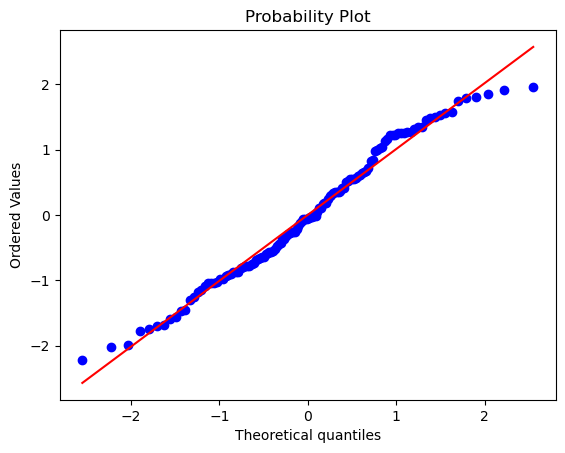

In [50]:
ss.probplot(x_train["Na_to_K"],dist="norm",fit=True,plot=plt)
plt.show()

In [51]:
# After applying Box-Cox our Na_to_K column is following normal distribution

In [52]:
x_cv["Na_to_K"]=pt2.transform(x_cv[["Na_to_K"]])
x_test["Na_to_K"]=pt2.transform(x_test[["Na_to_K"]])

Age


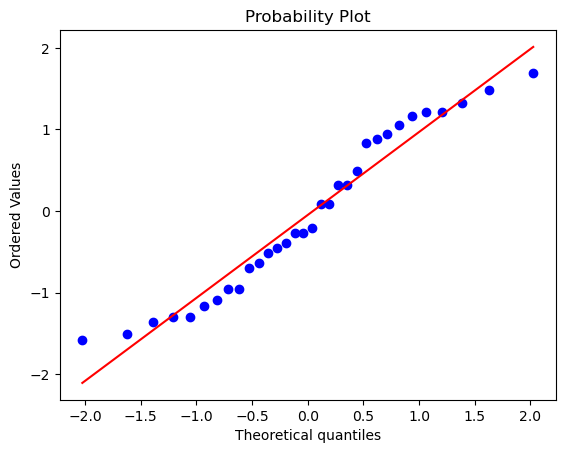

Na_to_K


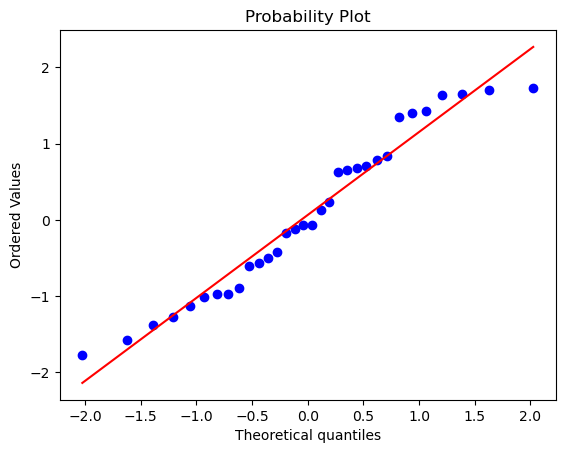

In [53]:
# Checking whether the Age and Na_to_K columns in x_cv and x_test data are following Guassian distribution or not
l=["Age","Na_to_K"]
for i in l:
    plt.subplot(111)
    print(i)
    ss.probplot(x_cv[i],dist="norm",fit=True,plot=plt)
    plt.show()

### 7.Training and evaluation

In [54]:
# As my dataset contains both categorical and numerical columns i can use mixed naive bayes algorithm to train my model
# Because for numerical we can use Guassian naive bayes, for categorical we use categorical naive bayes
# So in mixed naive bayes it applies Guassian naive bayes to numerical data and categorical naive bayes to categorical data

In [55]:
from mixed_naive_bayes import MixedNB

In [56]:
x_train

,Age,Sex,BP,Cholesterol,Na_to_K
98,-1.504660,1.0,0.0,1.0,1.843823
113,1.215585,0.0,1.0,1.0,-0.094137
128,0.206846,1.0,1.0,1.0,1.737463
160,-0.831415,0.0,2.0,0.0,-0.780612
169,-1.504660,0.0,0.0,0.0,-0.586933
...,...,...,...,...,...
111,0.206846,0.0,2.0,1.0,-2.028995
117,-0.208176,0.0,2.0,0.0,-0.867043
49,-0.961373,0.0,1.0,0.0,0.717752
156,-0.767177,1.0,0.0,1.0,-0.594824


In [57]:
from sklearn.metrics import accuracy_score

In [58]:
tr_error=[]
cv_error=[]
for i in range(1,31):
    mb=MixedNB(categorical_features=[1,2,3],alpha=i)
    model=mb.fit(x_train,y_train)
    pred_tr=model.predict(x_train)
    pred_cv=model.predict(x_cv)
    tr_error.append(1-accuracy_score(pred_tr,y_train))
    cv_error.append(1-accuracy_score(pred_cv,y_cv))

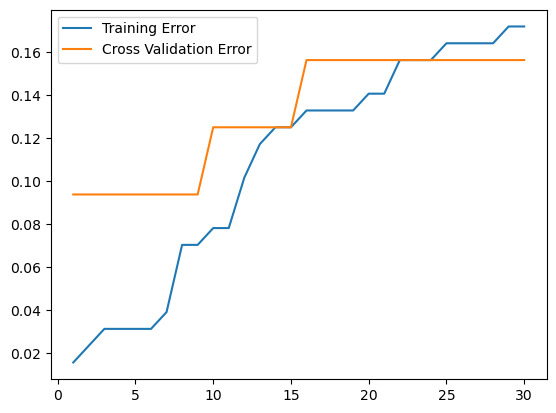

In [59]:
plt.plot(range(1,31),tr_error,label="Training Error")
plt.plot(range(1,31),cv_error,label="Cross Validation Error")
plt.legend()
plt.show()

In [60]:
from sklearn.metrics import confusion_matrix

In [61]:
mb=MixedNB(categorical_features=[1,2,3],alpha=3)
model=mb.fit(x_train,y_train)
prediction=model.predict(x_test)
print(confusion_matrix(y_test,prediction))

[[ 5  0  0  0  0]
 [ 0  3  0  0  0]
 [ 0  0  3  0  0]
 [ 0  0  0 11  0]
 [ 0  0  0  0 18]]


In [62]:
from sklearn.metrics import ConfusionMatrixDisplay

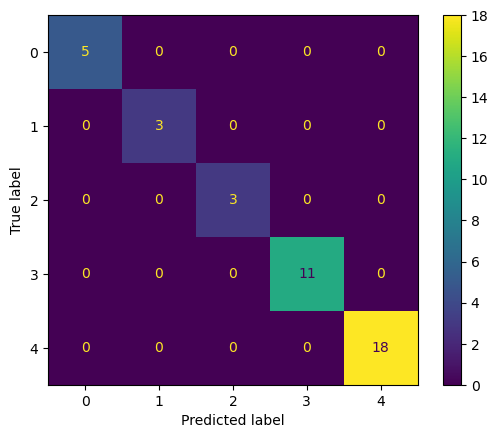

In [63]:
cm=confusion_matrix(y_test,prediction)
i=ConfusionMatrixDisplay(cm)
i.plot()
plt.show()

In [64]:
# But precision, recall and f1-score cannot be used for multiclass classification as we can't find TP,FP for multiclass
# Also we can't use roc metric for multiclass classification because to use roc we need to plot TPR,FPR values which will be not present in multiclass

In [65]:
# In the above confusion matrix all diagonal values are high and non diagonal values are low so it is a good model

In [66]:
# As my model with alpha=3 is giving 100% accuaracy i'm using this as my final model

In [67]:
prediction

array([4, 0, 1, 2, 4, 4, 1, 4, 0, 4, 3, 3, 4, 4, 0, 3, 3, 3, 0, 4, 3, 2,
       3, 3, 3, 4, 4, 4, 4, 4, 2, 3, 4, 4, 0, 4, 4, 4, 3, 1], dtype=int64)

In [87]:
# Testing by giving my own data

In [53]:
b=pd.DataFrame([[23,"M","HIGH","NORMAL",25.535]],columns=["Age","Sex","BP","Cholesterol","Na_to_K"])

In [65]:
b["Age"]=pt2.transform(b[["Age"]])

In [54]:
b["Sex"]=lb.transform(b["Sex"])

In [56]:
b["BP"]=lb.transform(b["BP"])

In [58]:
b["Cholesterol"]=lb.transform(b["Cholesterol"])

In [73]:
b["Na_to_K"]=pt2.transform(b[["Na_to_K"]])

In [88]:
model.predict(b)

array([4], dtype=int64)

In [ ]:
# My model predicts drug Y for the given data

### 8.Deployment

In [113]:
# As i have saved my cleaned dataset in my computer with name Drugs Clean i can load it into my notebook as
data=pd.read_csv(r"C:\Users\yuges\Drugs Clean.csv")

In [114]:
data

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,4
1,47,M,LOW,HIGH,13.093,2
2,47,M,LOW,HIGH,10.114,2
3,28,F,NORMAL,HIGH,7.798,3
4,61,F,LOW,HIGH,18.043,4
...,...,...,...,...,...,...
195,56,F,LOW,HIGH,11.567,2
196,16,M,LOW,HIGH,12.006,2
197,52,M,NORMAL,HIGH,9.894,3
198,23,M,NORMAL,NORMAL,14.020,3


In [115]:
# Now i am creating a pipeline which contains the transformation steps that i had applied in the above process
# Before creating pipeline i need to divide x_train dataset into three parts i.e. nominal,ordinal,numeric
fv=data.iloc[:,0:5]
cl=data.iloc[:,5]
x_train,x_test,y_train,y_test=train_test_split(fv,cl,test_size=0.2,random_state=1,stratify=cl)
x_train,x_cv,y_train,y_cv=train_test_split(x_train,y_train,test_size=0.2,random_state=1,stratify=y_train)

In [116]:
# Now dividing x_train into 3 datasets which has nominal,ordinal,numeric columns
numeric=x_train.select_dtypes(include=["int64","float64"])
nominal=x_train[["Sex"]]
ordinal=x_train[["BP","Cholesterol"]]

In [117]:
# Now creating a pipeline for these 3 datasets seperately
# In pipeline we don't need to mention the column name
nup=Pipeline([("boxcox",PowerTransformer(method="yeo-johnson"))])
nomp=Pipeline([("ohe",OneHotEncoder(sparse_output=False,drop="first"))])
ordp=Pipeline([("Ordinal",OrdinalEncoder())])

In [118]:
# As we have columns in different datatypes i need to seperate them and apply the steps in the pipeline to those seperated columns
# For this i need to use ColumnTransformer
# In column Transformer we need to mention the column name for which we want to apply the pipeline
ctp=ColumnTransformer(transformers=[("numeric",nup,numeric.columns),("Nominal",nomp,nominal.columns),("Ordinal",ordp,ordinal.columns)],remainder="passthrough")

In [119]:
ctp

ColumnTransformer(remainder='passthrough',
                  transformers=[('numeric',
                                 Pipeline(steps=[('boxcox',
                                                  PowerTransformer())]),
                                 Index(['Age', 'Na_to_K'], dtype='object')),
                                ('Nominal',
                                 Pipeline(steps=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False))]),
                                 Index(['Sex'], dtype='object')),
                                ('Ordinal',
                                 Pipeline(steps=[('Ordinal',
                                                  OrdinalEncoder())]),
                                 Index(['BP', 'Cholesterol'], dtype='object'))])

In [120]:
# In the above for numeric it applies PowerTransformer, for nominal it applies OneHotEncoder, for ordinal it applies OrdinalEncoder
# If there is any extra column which is not numeric,ordinal or nominal it skips the column

In [121]:
# Now i need to convert this columntransformer into pipeline to execute step by step process
final_pipe=Pipeline([("preprocessed data",ctp)])

In [122]:
final_pipe

Pipeline(steps=[('preprocessed data',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numeric',
                                                  Pipeline(steps=[('boxcox',
                                                                   PowerTransformer())]),
                                                  Index(['Age', 'Na_to_K'], dtype='object')),
                                                 ('Nominal',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False))]),
                                                  Index(['Sex'], dtype='object')),
                                                 ('Ordinal',
                                                  Pipeline(steps=[('Ordinal',
                                                                   OrdinalEncoder())]),
                                                  Index(['BP', 'Cholesterol'], dtype='object'))]))])

In [123]:
xtrainP=final_pipe.fit_transform(x_train)
xcvP=final_pipe.transform(x_cv)
xtestP=final_pipe.transform(x_test)

In [124]:
# My model that i had selected from the above process is mixed naive bayes with alpha value as 3
# We dropped a dimension in onehotencoding because features need to be independent with each other in Naive Bayes
mb=MixedNB(alpha=3,categorical_features=[2,3,4])
model=mb.fit(xtrainP,y_train)

In [125]:
# Now i had my pipeline and model so that i can deploy
pickle.dump(final_pipe,open(r"C:\Users\yuges\OneDrive\Desktop\drugs_pipe.pkl","wb"))
pickle.dump(model,open(r"C:\Users\yuges\OneDrive\Desktop\drugs_model.pkl","wb"))